<a href="https://colab.research.google.com/github/IMI1998/Video_classification/blob/main/Video_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import nltk
#nltk.download()
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt

In [2]:
vdata = pd.read_csv('/content/Videos_data.csv')
vdata.head(10)

,Unnamed: 0,Video Id,Title,Description,Category
0,0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel
3,3,#NAME?,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...,travel
4,4,7ByoBJYXU0k,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M...",travel
5,5,yvn79Rv0F48,Backpacking In Meghalaya | NorthEast India Tri...,"In this video I explored North East India, sta...",travel
6,6,SL_YBLWdZb8,Welcome to Peru! | Best Essential Tips &amp; T...,Welcome to Peru! This essential travel guide w...,travel
7,7,kiNyRY5s7n8,How to Start a Travel Blog [2019] Travel Blogg...,Create a Travel Blog Website for Just $3.95 + ...,travel
8,8,kY41XgTEEQU,A Day with KSRTC Bus Fans - Aanavandi Travel B...,ആനവണ്ടി ഭ്രാന്തൻമാരോടൊപ്പം കുമളിയിൽ ഒരു ദിവസം ...,travel
9,9,7mIzRYh8jGA,What is it like to travel in PAKISTAN?,Subscribe now: https://goo.gl/6zXZGK Watch the...,travel


In [3]:
data = vdata.drop(['Unnamed: 0'], axis = 1)

data.isnull().sum()

Video Id         0
Title            0
Description    334
Category         0
dtype: int64

In [4]:
print(data.shape)
data = data.dropna(how='any')
print(data.shape)

(10333, 4)
(9999, 4)


In [6]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
stop_words = set(stopwords.words('english'))
new_words = ["fig","figure","image","sample","using",
             "show", "result", "large",
             "also", "one", "two", "three",
             "four", "five", "seven","eight","nine"]
stop_words = list(stop_words.union(new_words))

In [8]:
def pre_process(text):

    text=text.lower()

    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)

    text=re.sub("(\\d|\\W)+"," ",text)

    text = text.split()

    text = [word for word in text if word not in stop_words]


    text = [word for word in text if len(word) >= 3]


    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word, "v") for word in text]

    return ' '.join(text)

In [9]:
data = data.sample(frac=1).reset_index(drop=True)
docs = pd.DataFrame()
docs['Title'] = data['Title'].iloc[:5000].apply(lambda x:pre_process(x))
docs['Description'] = data['Description'].iloc[:5000].apply(lambda x:pre_process(x))

In [10]:
docs.head()

,Title,Description
0,archaeological prospection,combine advance methods remote sense geophysic...
1,computers bad algebra infinite series,viewers like help make pbs thank support local...
2,hitler vader epic rap battle history,hitler vader square rematch end rematches epic...
3,fruit food art appetizers amp snack babble eat,make kid healthy snack fun look eat caterpilla...
4,orange goblin time travel blue full album,blue snow solarisphere shine man invent time d...


In [11]:
docs['classes'] = data['Category']
docs['classes'].value_counts()

classes
manufacturing             859
food                      854
travel                    832
science and technology    826
history                   818
art and music             811
Name: count, dtype: int64

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(docs['classes'])
docs['classes'] = le.transform(docs['classes'])
docs.head()

,Title,Description,classes
0,archaeological prospection,combine advance methods remote sense geophysic...,2
1,computers bad algebra infinite series,viewers like help make pbs thank support local...,4
2,hitler vader epic rap battle history,hitler vader square rematch end rematches epic...,2
3,fruit food art appetizers amp snack babble eat,make kid healthy snack fun look eat caterpilla...,1
4,orange goblin time travel blue full album,blue snow solarisphere shine man invent time d...,5


In [13]:
docs['classes'].value_counts()

classes
3    859
1    854
5    832
4    826
2    818
0    811
Name: count, dtype: int64

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_title = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidf_desc = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
labels = docs['classes']
features_title = tfidf_title.fit_transform(docs['Title']).toarray()
features_description = tfidf_desc.fit_transform(docs['Description']).toarray()
print('Title Features Shape: ' + str(features_title.shape))
print('Description Features Shape: ' + str(features_description.shape))

Title Features Shape: (5000, 1320)
Description Features Shape: (5000, 2654)


In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100


titles = docs['Title'].values
descriptions = docs['Description'].values
data_for_lstms = []
for i in range(len(titles)):
    temp_list = [titles[i], descriptions[i]]
    data_for_lstms.append(' '.join(temp_list))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_for_lstms)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(data_for_lstms)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(docs['classes']).values
print('Shape of label tensor:', Y.shape)


X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)

Found 16258 unique tokens.
Shape of data tensor: (5000, 50)
Shape of label tensor: (5000, 6)


In [17]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 1081006 (4.12 MB)
Trainable params: 1081006 (4.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [18]:
epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/10
24/24 [==============================] - 12s 311ms/step - loss: 1.7625 - accuracy: 0.2790 - val_loss: 1.6788 - val_accuracy: 0.4560
Epoch 2/10
24/24 [==============================] - 5s 212ms/step - loss: 1.3794 - accuracy: 0.5813 - val_loss: 1.0132 - val_accuracy: 0.6987
Epoch 3/10
24/24 [==============================] - 7s 293ms/step - loss: 0.5238 - accuracy: 0.8577 - val_loss: 0.3905 - val_accuracy: 0.8533
Epoch 4/10
24/24 [==============================] - 5s 216ms/step - loss: 0.1775 - accuracy: 0.9600 - val_loss: 0.2314 - val_accuracy: 0.9440
Epoch 5/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0590 - accuracy: 0.9913 - val_loss: 0.1591 - val_accuracy: 0.9707
Epoch 6/10
24/24 [==============================] - 6s 251ms/step - loss: 0.0436 - accuracy: 0.9923 - val_loss: 0.1563 - val_accuracy: 0.9667
Epoch 7/10
24/24 [==============================] - 5s 220ms/step - loss: 0.0257 - accuracy: 0.9957 - val_loss: 0.1525 - val_accuracy: 0.9733
Epoch

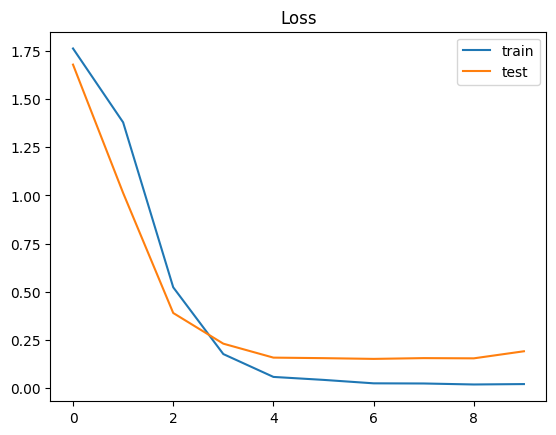

In [19]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

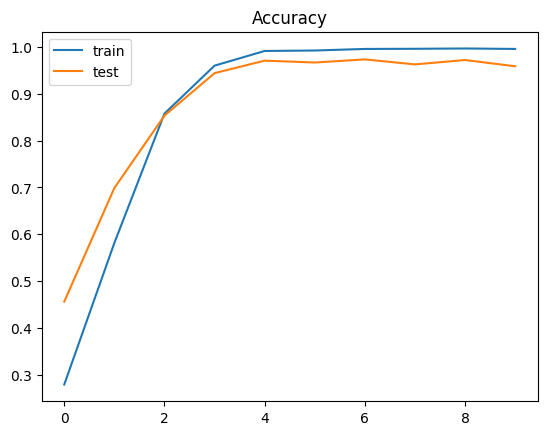

In [20]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [21]:
import pickle

pickle.dump(tokenizer, open('/video_classification-tokenizer.pkl', 'wb'))
model.save('/video_classification-model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
